# Practical Part: Neural Network Implementation & Experiments

Team:
* Jonathan Bhimani-Burrows (20178260)
* Arlie Coles (20121051)
* Yue (Violet) Guo (20120727)

Load the Fashion MNIST data:
Note: keep your file structures like this for reading input data without
using ```import os``` for path change!
```
./Homework 3
├── 3_practical_part.ipynb
├── circles.txt
├── data
│   ├── fashion
│   │   ├── t10k-images-idx3-ubyte.gz
│   │   ├── t10k-labels-idx1-ubyte.gz
│   │   ├── train-images-idx3-ubyte.gz
│   │   └── train-labels-idx1-ubyte.gz
│   └── mnist
│       └── README.md
├── hw3
│   └── d3english.pdf
├── overleaf_url.txt
└── utils
    ├── __init__.py
    ├── __pycache__
    │   ├── __init__.cpython-36.pyc
    │   └── mnist_reader.cpython-36.pyc
    ├── argparser.py
    ├── helper.py
    └── mnist_reader.py
```

In [1]:
import utils.mnist_reader as mnist_reader
import numpy as np
import math
import copy 

In [3]:
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

print(X_test.shape)

(10000, 784)


Load the Circles data:

In [4]:
circlesData = np.loadtxt(open('circles.txt','r'))
circlesTarget = circlesData[:,2]
circlesData = circlesData[:,[0,1]] 

print(circlesData.shape)
circlesTarget = np.array([int(i) for i in circlesTarget])
print(circlesTarget)

(1100, 2)
[1 1 0 ... 0 1 1]


In [5]:
class loadData:
    def __init__(self):
        self.addOnes = False
        self.data_path = '/data/'
    
    def convertTarget(self, targetValues):
        # Convert to one-hot encoding
        numClasses = np.max(targetValues) + 1
        return np.eye(numClasses)[targetValues]

    def loadNumData(self, data, target):
        # Split into train/validation/test
        np.random.seed(6390)
        randIndices = np.random.permutation(data.shape[0])
        data, target = data[randIndices], target[randIndices]
        
        div1 = int(math.floor(0.8 * data.shape[0]))
        div2 = int(math.floor(0.9 * data.shape[0]))
        trainData, trainTarget = data[:div1], target[:div1]
        validData, validTarget = data[div1:div2], target[div1:div2]
        testData, testTarget = data[div2:], target[div2:]
    
        # Get one hot encoding
        trainTarget = self.convertTarget(trainTarget)
        validTarget = self.convertTarget(validTarget)
        testTarget = self.convertTarget(testTarget)
        
        return trainData, trainTarget, validData, validTarget, testData, testTarget

dataLoader = loadData()
 
trainData, trainTarget, validData, validTarget, testData, testTarget = dataLoader.loadNumData(circlesData, circlesTarget)
print(trainData.shape, validData.shape, testData.shape)

print(trainTarget.shape)

(880, 2) (110, 2) (110, 2)
(880, 2)


## Experiments

### Part 1

> As a beginning, start with an implementation that computes the gradients for a single example, and check that the gradient is correct using the finite difference method described above.

In [6]:
class BatchSampler(object):
    '''
    A (very) simple wrapper to randomly sample batches without replacement.
    '''
    
    def __init__(self, data, targets, batch_size):
        self.num_points = data.shape[0]
        self.features = data.shape[1]
        self.data = data
        self.targets = targets
        self.batch_size = batch_size
        self.indices = np.arange(self.num_points)

    def random_batch_indices(self, m=None):
        if m is None:
            indices = np.random.choice(self.indices, self.batch_size, replace=False)
        else:
            indices = np.random.choice(self.indices, m, replace=False)
        return indices 

    def get_batch(self, m=None):
        '''
        Get a random batch without replacement from the dataset.
        If m is given the batch will be of size m. 
        Otherwise will default to the class initialized value.
        '''
        indices = self.random_batch_indices(m)
        X_batch = np.take(self.data, indices, 0)
        y_batch = self.targets[indices]
        return X_batch, y_batch

In [7]:
# Our own activation functions

def relu(pre_activation):
    '''
    preactivation is a vector
    '''
    relu_output = np.zeros(pre_activation.shape)
    relu_flat = relu_output.flatten()
    for i, neuron in enumerate(pre_activation.flatten()):
        if neuron > 0:
            relu_flat[i] = neuron
    relu_output = relu_flat.reshape(pre_activation.shape)
    return relu_output

def softmax(pre_activation):
    '''
    Numerically stable because subtracting the max value makes bit overflow impossible,
    we will only have non-positive values in the vector
    '''
    exps = np.exp(pre_activation - np.max(pre_activation))
    return exps / np.sum(exps)

In [8]:
w1_fixed = np.array([[ 0.20960823 , 0.13663559], [ 0.38623373, -0.32807251] ,[-0.63849439 , 0.0131154 ],
                     [ 0.5142807 ,  0.0595152 ], [-0.31075243 , 0.52335846]])
w2_fixed = np.array( [[ 0.06159592, -0.10424877,  0.23591191 , 0.06177611 , 0.42799154],
                      [ 0.40780062,  0.0759027  , 0.09284926, -0.14837115 ,  0.16844463]])

In [156]:
class neuralNet():
    def __init__(self, d, dh, m, n, eta=1, regularize=None, fixed=False):
        self.inputDim = d #inputDim
        self.hiddenDim = dh #hiddenDim
        self.outputDim = m #outputDim
        self.regularize = regularize # lambda value
        self.learningRate = eta
        self.numData = n
        self.batchErrorGradients = []
        
        # Initial weights and biases
        if fixed:
            self.W_1 = w1_fixed
            self.W_2 = w2_fixed
        else:   
            self.W_1 = np.random.uniform(-1/np.sqrt(d), 1/np.sqrt(d), d*dh).reshape(dh, d)
            self.W_2 = np.random.uniform(-1/np.sqrt(dh), 1/np.sqrt(dh), dh*m).reshape(m, dh) 
            
        self.b_1 = np.zeros(dh).reshape(dh,)
        self.b_2 = np.zeros(m).reshape(m,)

        
    def fprop(self, batchData):
        self.h_a = np.dot(self.W_1, batchData.T) + self.b_1
        self.h_s = relu(self.h_a)
        self.o_a = np.dot(self.W_2, self.h_s) + self.b_2
        self.o_s = softmax(self.o_a)
        self.prediction = np.argmax(self.o_s,axis = 0)

    def errorRate(self, y, mode='matrix'):
        '''
        negative log
        -logO_s(x)
        '''        
        
        if mode == 'loop':
            negLog = -self.o_a[np.argmax(y)] + np.log(np.sum(np.exp(self.o_a), axis=0))
            
        elif mode == 'matrix':
            negLog = []
            print('num data from error function:', self.numData)
            for i in range(self.numData):
                error_at_point = -self.o_a[np.argmax(y[:,i])][i] + np.log(np.sum(np.exp(self.o_a), axis=0))[i]
                negLog.append(error_at_point)
            negLog = np.array(negLog)
            negLog = np.mean(negLog)

        return negLog
          
    def bpropLoop(self, batchData, batchTarget):
        self.grad_oa = self.o_s - batchTarget
        self.grad_W2 = np.outer(self.grad_oa, self.h_s.T)
        self.grad_b2 = self.grad_oa
        self.grad_hs = np.dot(self.W_2.T , self.grad_oa)
        h_a_stack = np.where(self.h_a > 0, 1, 0)
        self.grad_ha = np.multiply(self.grad_hs, h_a_stack)
        self.grad_W1 = np.outer(self.grad_ha, batchData)
        self.grad_b1 = self.grad_ha
        
    def bprop(self, batchData, batchTarget):
        '''
        batchTarget already in one-hot format
        '''
    
        self.grad_oa = self.o_s - batchTarget
        self.grad_W2 = [np.outer(self.grad_oa[:,i], self.h_s[:,i].T) for i in range(self.numData)]
        self.grad_b2 = self.grad_oa #np.mean(self.grad_oa, axis = 1)        
        self.grad_hs = np.dot(self.W_2.T , self.grad_oa)
        h_a_stack = np.where(self.h_a > 0, 1, 0)
        self.grad_ha = np.multiply(self.grad_hs, h_a_stack)
        self.grad_W1 = [np.outer(self.grad_ha[:,i], batchData[i]) for i in range(self.numData)]
        self.grad_b1 = self.grad_ha

    def updateParams(self):
        if self.regularize:
            self.W_1 -= (self.regularize[0] * np.sign(self.W_1) + 2 * self.regularize[1] * self.W_1) * self.learningRate
            self.W_2 -= (self.regularize[2] * np.sign(self.W_2) + 2 * self.regularize[3] * self.W_2) * self.learningRate
        
        self.W_1 -= self.grad_W1 * self.learningRate
        self.W_2 -= self.grad_W2 * self.learningRate
        self.b_1 -= self.grad_b1 * self.learningRate
        self.b_2 -= self.grad_b2 * self.learningRate
    
    def gradDescentLoop(self, batchData, batchTarget, K):
        # Call each example in the data (over the minibatches) in a loop
        grad_W2, grad_b2, grad_W1, grad_b1 = [], [], [], []
        predBatch = []
        for i in range(K):
            self.fprop(batchData[i]) #batchTarget[:,i]
            self.bpropLoop(batchData[i],np.array(batchTarget[:,i]))
            predBatch.append(self.prediction)
            grad_W2.append(self.grad_W2)
            grad_b2.append(self.grad_b2)
            grad_W1.append(self.grad_W1)
            grad_b1.append(self.grad_b1)
        self.grad_W2 = np.mean(grad_W2, axis=0)
        self.grad_b2 = np.mean(grad_b2, axis=0)
        self.grad_W1 = np.mean(grad_W1, axis=0)
        self.grad_b1 = np.mean(grad_b1, axis=0)
        
    def fpropLoop(self, batchData, K):
        '''
        unlike the above def gradDescentLoop(self, batchData, batchTarget, K)
        this function only runs batchData (this is usually in test phase)
        through the forward prop, without calculating any gradient update rule.
        
        Use to get predictions
        
        batchData: more like test/val data
        K: ALWAYS == batchData.shape[0]
        
        '''
        predBatch = []
        for i in range(K):
            self.fprop(batchData[i]) #batchTarget[:,i]
            predBatch.append(self.prediction)
        self.predBatch = np.array(predBatch)
        

We calculate the gradients for a simple network with a single example:

In [58]:
x_i = trainData[0:1]
y_i = trainTarget[0:1].T

nn = neuralNet(2, 2, 2, 1)
nn.gradDescentLoop(x_i, y_i, 1)

print('Gradient for W2:\n', nn.grad_W2)
print('Gradient for b2:\n', nn.grad_b2)
print('Gradient for W1:\n', nn.grad_W1)
print('Gradient for b1:\n', nn.grad_b1)

Gradient for W2:
 [[ 0.         -0.03056778]
 [ 0.          0.03056778]]
Gradient for b2:
 [-0.49642669  0.49642669]
Gradient for W1:
 [[ 0.          0.        ]
 [-0.09549319  0.06449919]]
Gradient for b1:
 [ 0.         -0.11523496]


Now we verify these gradients by finite difference estimation:

In [91]:
# Note to TAs: we attempted this with a loop, but deep/shallow copying issues got in the way.
x_i = trainData[0:1]
y_i = trainTarget[0:1].T
sigma = 1e-5
nn = neuralNet(2, 2, 2, 1)

# Perturbing W2
# 1 of 4 elements to perturb
nn.gradDescentLoop(x_i, y_i, 1)
grad_W2 = nn.grad_W2
oldErr = []
for i in y_i.T:
    oldErr.append(nn.errorRate(i, mode='loop'))
oldErr= np.array(oldErr)
nnDebug = copy.deepcopy(nn)
nnDebug.W_2[0][0] += sigma
nnDebug.gradDescentLoop(x_i, y_i, 1)
newErr = []
for i in y_i.T:
    newErr.append(nnDebug.errorRate(i, mode='loop'))
newErr = np.array(newErr)
estimate = (newErr - oldErr) / 1e-5
ratio = estimate / grad_W2[0][0]
print('Perturbing an element in W2. Ratio:', ratio)

# 2 of 4 elements to perturb
grad_W2 = nn.grad_W2
oldErr = []
for i in y_i.T:
    oldErr.append(nn.errorRate(i, mode='loop'))
oldErr= np.array(oldErr)
nnDebug = copy.deepcopy(nn)
nnDebug.W_2[0][1] += sigma
nnDebug.gradDescentLoop(x_i, y_i, 1)
newErr = []
for i in y_i.T:
    newErr.append(nnDebug.errorRate(i, mode='loop'))
newErr = np.array(newErr)
estimate = (newErr - oldErr) / 1e-5
ratio = estimate / grad_W2[0][1]
print('Perturbing an element in W2. Ratio:', ratio)

# 3 of 4 elements to perturb
grad_W2 = nn.grad_W2
oldErr = []
for i in y_i.T:
    oldErr.append(nn.errorRate(i, mode='loop'))
oldErr= np.array(oldErr)
nnDebug = copy.deepcopy(nn)
nnDebug.W_2[1][0] += sigma
nnDebug.gradDescentLoop(x_i, y_i, 1)
newErr = []
for i in y_i.T:
    newErr.append(nnDebug.errorRate(i, mode='loop'))
newErr = np.array(newErr)
estimate = (newErr - oldErr) / 1e-5
ratio = estimate / grad_W2[1][0]
print('Perturbing an element in W2. Ratio:', ratio)

# 4 of 4 elements to perturb
grad_W2 = nn.grad_W2
oldErr = []
for i in y_i.T:
    oldErr.append(nn.errorRate(i, mode='loop'))
oldErr= np.array(oldErr)
nnDebug = copy.deepcopy(nn)
nnDebug.W_2[1][1] += sigma
nnDebug.gradDescentLoop(x_i, y_i, 1)
newErr = []
for i in y_i.T:
    newErr.append(nnDebug.errorRate(i, mode='loop'))
newErr = np.array(newErr)
estimate = (newErr - oldErr) / 1e-5
ratio = estimate / grad_W2[1][1]
print('Perturbing an element in W2. Ratio:', ratio)

# Perturbing b2
# 1 of 2 elements to perturb
grad_b2 = nn.grad_b2
oldErr = []
for i in y_i.T:
    oldErr.append(nn.errorRate(i, mode='loop'))
oldErr= np.array(oldErr)
nnDebug = copy.deepcopy(nn)
nnDebug.b_2[0] += sigma
nnDebug.gradDescentLoop(x_i, y_i, 1)
newErr = []
for i in y_i.T:
    newErr.append(nnDebug.errorRate(i, mode='loop'))
newErr = np.array(newErr)
estimate = (newErr - oldErr) / 1e-5
ratio = estimate / grad_b2[0]
print('Perturbing an element in b2. Ratio:', ratio)

# 2 of 2 elements to perturb
grad_b2 = nn.grad_b2
oldErr = []
for i in y_i.T:
    oldErr.append(nn.errorRate(i, mode='loop'))
oldErr= np.array(oldErr)
nnDebug = copy.deepcopy(nn)
nnDebug.b_2[1] += sigma
nnDebug.gradDescentLoop(x_i, y_i, 1)
newErr = []
for i in y_i.T:
    newErr.append(nnDebug.errorRate(i, mode='loop'))
newErr = np.array(newErr)
estimate = (newErr - oldErr) / 1e-5
ratio = estimate / grad_b2[1]
print('Perturbing an element in b2. Ratio:', ratio)

# Perturbing W1
# 1 of 4 elements to perturb
nn.gradDescentLoop(x_i, y_i, 1)
grad_W1 = nn.grad_W1
oldErr = []
for i in y_i.T:
    oldErr.append(nn.errorRate(i, mode='loop'))
oldErr= np.array(oldErr)
nnDebug = copy.deepcopy(nn)
nnDebug.W_1[0][0] += sigma
nnDebug.gradDescentLoop(x_i, y_i, 1)
newErr = []
for i in y_i.T:
    newErr.append(nnDebug.errorRate(i, mode='loop'))
newErr = np.array(newErr)
estimate = (newErr - oldErr) / 1e-5
ratio = estimate / grad_W1[0][0]
print('Perturbing an element in W1. Ratio:', ratio)

# 2 of 4 elements to perturb
grad_W1 = nn.grad_W1
oldErr = []
for i in y_i.T:
    oldErr.append(nn.errorRate(i, mode='loop'))
oldErr= np.array(oldErr)
nnDebug = copy.deepcopy(nn)
nnDebug.W_1[0][1] += sigma
nnDebug.gradDescentLoop(x_i, y_i, 1)
newErr = []
for i in y_i.T:
    newErr.append(nnDebug.errorRate(i, mode='loop'))
newErr = np.array(newErr)
estimate = (newErr - oldErr) / 1e-5
ratio = estimate / grad_W1[0][1]
print('Perturbing an element in W1. Ratio:', ratio)

# 3 of 4 elements to perturb
grad_W1 = nn.grad_W1
oldErr = []
for i in y_i.T:
    oldErr.append(nn.errorRate(i, mode='loop'))
oldErr= np.array(oldErr)
nnDebug = copy.deepcopy(nn)
nnDebug.W_1[1][0] += sigma
nnDebug.gradDescentLoop(x_i, y_i, 1)
newErr = []
for i in y_i.T:
    newErr.append(nnDebug.errorRate(i, mode='loop'))
newErr = np.array(newErr)
estimate = (newErr - oldErr) / 1e-5
ratio = estimate / grad_W1[1][0]
print('Perturbing an element in W1. Ratio:', ratio)

# 4 of 4 elements to perturb
grad_W1 = nn.grad_W1
oldErr = []
for i in y_i.T:
    oldErr.append(nn.errorRate(i, mode='loop'))
oldErr= np.array(oldErr)
nnDebug = copy.deepcopy(nn)
nnDebug.W_1[1][1] += sigma
nnDebug.gradDescentLoop(x_i, y_i, 1)
newErr = []
for i in y_i.T:
    newErr.append(nnDebug.errorRate(i, mode='loop'))
newErr = np.array(newErr)
estimate = (newErr - oldErr) / 1e-5
ratio = estimate / grad_W1[1][1]
print('Perturbing an element in W1. Ratio:', ratio)

# Perturbing b1
# 1 of 2 elements to perturb
grad_b1 = nn.grad_b1
oldErr = []
for i in y_i.T:
    oldErr.append(nn.errorRate(i, mode='loop'))
oldErr= np.array(oldErr)
nnDebug = copy.deepcopy(nn)
nnDebug.b_1[0] += sigma
nnDebug.gradDescentLoop(x_i, y_i, 1)
newErr = []
for i in y_i.T:
    newErr.append(nnDebug.errorRate(i, mode='loop'))
newErr = np.array(newErr)
estimate = (newErr - oldErr) / 1e-5
ratio = estimate / grad_b1[0]
print('Perturbing an element in b1. Ratio:', ratio)

# 2 of 2 elements to perturb
grad_b1 = nn.grad_b1
oldErr = []
for i in y_i.T:
    oldErr.append(nn.errorRate(i, mode='loop'))
oldErr= np.array(oldErr)
nnDebug = copy.deepcopy(nn)
nnDebug.b_1[1] += sigma
nnDebug.gradDescentLoop(x_i, y_i, 1)
newErr = []
for i in y_i.T:
    newErr.append(nnDebug.errorRate(i, mode='loop'))
newErr = np.array(newErr)
estimate = (newErr - oldErr) / 1e-5
ratio = estimate / grad_b1[1]
print('Perturbing an element in b1. Ratio:', ratio)

Perturbing an element in W2. Ratio: [0.99999983]
Perturbing an element in W2. Ratio: [0.99999849]
Perturbing an element in W2. Ratio: [1.00000017]
Perturbing an element in W2. Ratio: [1.00000151]
Perturbing an element in b2. Ratio: [0.99999785]
Perturbing an element in b2. Ratio: [1.00000215]
Perturbing an element in W1. Ratio: [1.00000091]
Perturbing an element in W1. Ratio: [0.99999938]
Perturbing an element in W1. Ratio: [1.00000061]
Perturbing an element in W1. Ratio: [0.99999959]
Perturbing an element in b1. Ratio: [1.0000011]
Perturbing an element in b1. Ratio: [1.00000074]


### Part 2

> Display  the  gradients  for  both  methods (direct computation and finite difference) for a small network (e.g. $d = 2$ and $d_{h} = 2$) with random weights and for a single example.

See above.

### Part 3

> Add a hyperparameter for the minibatch size $K$ to allow computing the gradients on a minibatch of $K$ examples (in a matrix), by looping over the $K$ examples (this is a small addition to your previous code).

See the above `neuralNet` class.

### Part 4

> Display the gradients for both methods (direct computation and finite difference) for a small network (e.g. $d = 2$ and $d_{h} = 2$) with random weights and for a minibatch with 10 examples (you can use examples from both classes from the two circles dataset).

In [96]:
# Note to TAs: we attempted this with a loop, but deep/shallow copying issues got in the way.
x_i = trainData[0:10]
y_i = trainTarget[0:10].T
sigma = 1e-5
nn = neuralNet(2, 2, 2, 10)

# Perturbing W2
# 1 of 4 elements to perturb
nn.gradDescentLoop(x_i, y_i, 1)
print('Gradient of W2:\n', nn.grad_W2)
print('Gradient of b2:\n', nn.grad_b2)
print('Gradient of W1:\n', nn.grad_W1)
print('Gradient of b1:\n', nn.grad_b1)
print()

grad_W2 = nn.grad_W2
oldErr = []
for i in y_i.T:
    oldErr.append(nn.errorRate(i, mode='loop'))
oldErr= np.array(oldErr)
nnDebug = copy.deepcopy(nn)
nnDebug.W_2[0][0] += sigma
nnDebug.gradDescentLoop(x_i, y_i, 1)
newErr = []
for i in y_i.T:
    newErr.append(nnDebug.errorRate(i, mode='loop'))
newErr = np.array(newErr)
estimate = (newErr - oldErr) / 1e-5
ratio = estimate / grad_W2[0][0]
print('Perturbing an element in W2. Ratio:', ratio)

# 2 of 4 elements to perturb
grad_W2 = nn.grad_W2
oldErr = []
for i in y_i.T:
    oldErr.append(nn.errorRate(i, mode='loop'))
oldErr= np.array(oldErr)
nnDebug = copy.deepcopy(nn)
nnDebug.W_2[0][1] += sigma
nnDebug.gradDescentLoop(x_i, y_i, 1)
newErr = []
for i in y_i.T:
    newErr.append(nnDebug.errorRate(i, mode='loop'))
newErr = np.array(newErr)
estimate = (newErr - oldErr) / 1e-5
ratio = estimate / grad_W2[0][1]
print('Perturbing an element in W2. Ratio:', ratio)

# 3 of 4 elements to perturb
grad_W2 = nn.grad_W2
oldErr = []
for i in y_i.T:
    oldErr.append(nn.errorRate(i, mode='loop'))
oldErr= np.array(oldErr)
nnDebug = copy.deepcopy(nn)
nnDebug.W_2[1][0] += sigma
nnDebug.gradDescentLoop(x_i, y_i, 1)
newErr = []
for i in y_i.T:
    newErr.append(nnDebug.errorRate(i, mode='loop'))
newErr = np.array(newErr)
estimate = (newErr - oldErr) / 1e-5
ratio = estimate / grad_W2[1][0]
print('Perturbing an element in W2. Ratio:', ratio)

# 4 of 4 elements to perturb
grad_W2 = nn.grad_W2
oldErr = []
for i in y_i.T:
    oldErr.append(nn.errorRate(i, mode='loop'))
oldErr= np.array(oldErr)
nnDebug = copy.deepcopy(nn)
nnDebug.W_2[1][1] += sigma
nnDebug.gradDescentLoop(x_i, y_i, 1)
newErr = []
for i in y_i.T:
    newErr.append(nnDebug.errorRate(i, mode='loop'))
newErr = np.array(newErr)
estimate = (newErr - oldErr) / 1e-5
ratio = estimate / grad_W2[1][1]
print('Perturbing an element in W2. Ratio:', ratio)

# Perturbing b2
# 1 of 2 elements to perturb
grad_b2 = nn.grad_b2
oldErr = []
for i in y_i.T:
    oldErr.append(nn.errorRate(i, mode='loop'))
oldErr= np.array(oldErr)
nnDebug = copy.deepcopy(nn)
nnDebug.b_2[0] += sigma
nnDebug.gradDescentLoop(x_i, y_i, 1)
newErr = []
for i in y_i.T:
    newErr.append(nnDebug.errorRate(i, mode='loop'))
newErr = np.array(newErr)
estimate = (newErr - oldErr) / 1e-5
ratio = estimate / grad_b2[0]
print('Perturbing an element in b2. Ratio:', ratio)

# 2 of 2 elements to perturb
grad_b2 = nn.grad_b2
oldErr = []
for i in y_i.T:
    oldErr.append(nn.errorRate(i, mode='loop'))
oldErr= np.array(oldErr)
nnDebug = copy.deepcopy(nn)
nnDebug.b_2[1] += sigma
nnDebug.gradDescentLoop(x_i, y_i, 1)
newErr = []
for i in y_i.T:
    newErr.append(nnDebug.errorRate(i, mode='loop'))
newErr = np.array(newErr)
estimate = (newErr - oldErr) / 1e-5
ratio = estimate / grad_b2[1]
print('Perturbing an element in b2. Ratio:', ratio)

# Perturbing W1
# 1 of 4 elements to perturb
nn.gradDescentLoop(x_i, y_i, 1)
grad_W1 = nn.grad_W1
oldErr = []
for i in y_i.T:
    oldErr.append(nn.errorRate(i, mode='loop'))
oldErr= np.array(oldErr)
nnDebug = copy.deepcopy(nn)
nnDebug.W_1[0][0] += sigma
nnDebug.gradDescentLoop(x_i, y_i, 1)
newErr = []
for i in y_i.T:
    newErr.append(nnDebug.errorRate(i, mode='loop'))
newErr = np.array(newErr)
estimate = (newErr - oldErr) / 1e-5
ratio = estimate / grad_W1[0][0]
print('Perturbing an element in W1. Ratio:', ratio)

# 2 of 4 elements to perturb
grad_W1 = nn.grad_W1
oldErr = []
for i in y_i.T:
    oldErr.append(nn.errorRate(i, mode='loop'))
oldErr= np.array(oldErr)
nnDebug = copy.deepcopy(nn)
nnDebug.W_1[0][1] += sigma
nnDebug.gradDescentLoop(x_i, y_i, 1)
newErr = []
for i in y_i.T:
    newErr.append(nnDebug.errorRate(i, mode='loop'))
newErr = np.array(newErr)
estimate = (newErr - oldErr) / 1e-5
ratio = estimate / grad_W1[0][1]
print('Perturbing an element in W1. Ratio:', ratio)

# 3 of 4 elements to perturb
grad_W1 = nn.grad_W1
oldErr = []
for i in y_i.T:
    oldErr.append(nn.errorRate(i, mode='loop'))
oldErr= np.array(oldErr)
nnDebug = copy.deepcopy(nn)
nnDebug.W_1[1][0] += sigma
nnDebug.gradDescentLoop(x_i, y_i, 1)
newErr = []
for i in y_i.T:
    newErr.append(nnDebug.errorRate(i, mode='loop'))
newErr = np.array(newErr)
estimate = (newErr - oldErr) / 1e-5
ratio = estimate / grad_W1[1][0]
print('Perturbing an element in W1. Ratio:', ratio)

# 4 of 4 elements to perturb
grad_W1 = nn.grad_W1
oldErr = []
for i in y_i.T:
    oldErr.append(nn.errorRate(i, mode='loop'))
oldErr= np.array(oldErr)
nnDebug = copy.deepcopy(nn)
nnDebug.W_1[1][1] += sigma
nnDebug.gradDescentLoop(x_i, y_i, 1)
newErr = []
for i in y_i.T:
    newErr.append(nnDebug.errorRate(i, mode='loop'))
newErr = np.array(newErr)
estimate = (newErr - oldErr) / 1e-5
ratio = estimate / grad_W1[1][1]
print('Perturbing an element in W1. Ratio:', ratio)

# Perturbing b1
# 1 of 2 elements to perturb
grad_b1 = nn.grad_b1
oldErr = []
for i in y_i.T:
    oldErr.append(nn.errorRate(i, mode='loop'))
oldErr= np.array(oldErr)
nnDebug = copy.deepcopy(nn)
nnDebug.b_1[0] += sigma
nnDebug.gradDescentLoop(x_i, y_i, 1)
newErr = []
for i in y_i.T:
    newErr.append(nnDebug.errorRate(i, mode='loop'))
newErr = np.array(newErr)
estimate = (newErr - oldErr) / 1e-5
ratio = estimate / grad_b1[0]
print('Perturbing an element in b1. Ratio:', ratio)

# 2 of 2 elements to perturb
grad_b1 = nn.grad_b1
oldErr = []
for i in y_i.T:
    oldErr.append(nn.errorRate(i, mode='loop'))
oldErr= np.array(oldErr)
nnDebug = copy.deepcopy(nn)
nnDebug.b_1[1] += sigma
nnDebug.gradDescentLoop(x_i, y_i, 1)
newErr = []
for i in y_i.T:
    newErr.append(nnDebug.errorRate(i, mode='loop'))
newErr = np.array(newErr)
estimate = (newErr - oldErr) / 1e-5
ratio = estimate / grad_b1[1]
print('Perturbing an element in b1. Ratio:', ratio)

Gradient of W2:
 [[-0.17793466 -0.27200777]
 [ 0.17793466  0.27200777]]
Gradient of b2:
 [-0.50403059  0.50403059]
Gradient of W1:
 [[-0.36610069  0.24727624]
 [ 0.25196422 -0.17018478]]
Gradient of b1:
 [-0.44178644  0.30405399]

Perturbing an element in W2. Ratio: [ 0.99999912  0.99999912  0.99999912 -0.98400742  0.99999912  0.99999912
  0.99999912 -0.98400742  0.99999912  0.99999912]
Perturbing an element in W2. Ratio: [ 0.99999866  0.99999866  0.99999866 -0.98400789  0.99999866  0.99999866
  0.99999866 -0.98400789  0.99999866  0.99999866]
Perturbing an element in W2. Ratio: [ 1.00000088  1.00000088  1.00000088 -0.98400567  1.00000088  1.00000088
  1.00000088 -0.98400567  1.00000088  1.00000088]
Perturbing an element in W2. Ratio: [ 1.00000134  1.00000134  1.00000134 -0.98400521  1.00000134  1.00000134
  1.00000134 -0.98400521  1.00000134  1.00000134]
Perturbing an element in b2. Ratio: [ 0.99999752  0.99999752  0.99999752 -0.98400903  0.99999752  0.99999752
  0.99999752 -0.98400903

### Part 5

> Train your neural network using gradient descent on the two circles dataset. Plot the decision regions for several different values of the hyperparameters (weight decay, number of hidden units, early stopping) so as to illustrate their effect on the capacity of the model.

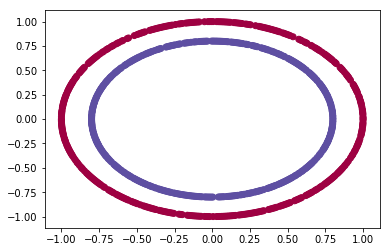

In [100]:
# plot the circle training dataset
import matplotlib.pyplot as plt
plotTrainTarget = np.argmax(trainTarget, axis = 1)
plt.scatter(trainData[:,0], trainData[:,1], c=plotTrainTarget, cmap=plt.cm.Spectral)
plt.show()

In [122]:
def train_loop(nn, data, target, K, num_epoch, fixed=False, valid=None, test=None): 
    '''
    train minibtaches over K epochs (in a loop)
    also does prediction and error calcualation
    '''
    # Get minibatch
    batchSampler = BatchSampler(data, target, K)
    numBatch = data.shape[0] // K 
    # training loop
    for n in range(num_epoch):
        # Do descent and update params - this is one epoch
        for i in range(numBatch):
            if fixed:
                batchData, batchTarget = batchSampler.get_batch(K)
            elif not fixed:
                batchData, batchTarget = batchSampler.get_batch()
            #difference: another loop here
            nn.gradDescentLoop(batchData, batchTarget.T, K)
            nn.updateParams()
        if n % 100 == 0:
            nn.fpropLoop(data, data.shape[0]) 
            print("Cross-entropy loss at the end of epoch {}: {}".format(n, nn.errorRate(target.T, mode = 'loop')))
            print("classification error at the end of epoch {}: {}".format(n,
                                                    classErr(np.argmax(target, axis = 1), nn.predBatch)))
        '''if valid:
            nn.numData = valid[0].shape[0]
            nn.fprop(valid[0]) 
            valid_loss = nn.errorRate(valid[1].T)
            nn.numData = test[0].shape[0]
            #nn.fprop(test[0]) 
            #test_loss = nn.errorRate(test[1].T)'''
    
    # finalized weights, need to fprop and get the error rate 
    # a for loop inside the prop for each elem
    nn.fpropLoop(data, data.shape[0]) 
    print("End of train loop process.")

In [124]:
def classErr(target, predicted):
    cnt = 0
    for i in range(target.shape[0]):
        if target[i] != predicted [i]:
            cnt +=1
    return float(cnt) / target.shape[0]

In [114]:
def plot_decision_boundary(nn, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h betweethem
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    
    newData =np.c_[xx.ravel(), yy.ravel()]
    
    nn.fpropLoop(newData, newData.shape[0])
    Z = nn.predBatch
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.show()
    
def plotDecision(nn, data):
    nn.fpropLoop(data, data.shape[0])
    plt.scatter(data[:,0], data[:,1], c = nn.predBatch)
    plt.show()

Varying the number of hidden units:

Cross-entropy loss at the end of epoch 0: 0.8079721600016513
classification error at the end of epoch 0: 0.275
End of train loop process.
Plotting the decision boundary for number of hidden units = 10.


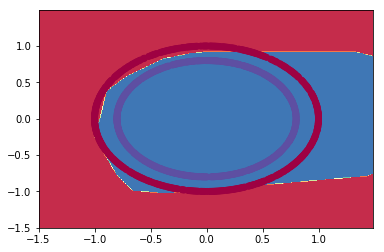

Cross-entropy loss at the end of epoch 0: 0.6834391260947186
classification error at the end of epoch 0: 0.22045454545454546
End of train loop process.
Plotting the decision boundary for number of hidden units = 25.


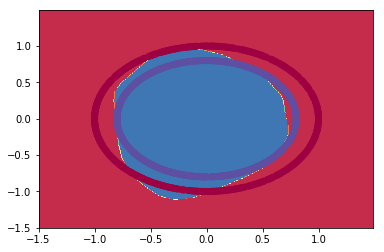

Cross-entropy loss at the end of epoch 0: 1.6395531292905623
classification error at the end of epoch 0: 0.4965909090909091
End of train loop process.
Plotting the decision boundary for number of hidden units = 50.


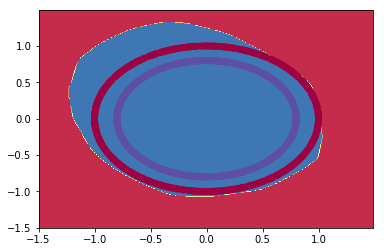

In [128]:
# Train on circles, varying number of hidden units
# K is Size of batches
K = 10

num_hidden = [10,25,50]
for hidden in num_hidden:
    circleNet = neuralNet(2, hidden, 2, K) 
    train_loop(circleNet, trainData, trainTarget, K, 1)
    #train_matrix(circleNet, trainData, trainTarget, K, 1)
    print('Plotting the decision boundary for number of hidden units = {}.'.format(hidden))
    plot_decision_boundary(circleNet,trainData, np.argmax(trainTarget, axis = 1))

We can see that as the number of hidden units increases, the capacity of the model also increases. The extra accuracy yielded by the increased capacity also increases, up to a point, before it will start to probably overfit.

Next we vary the number of epochs (looking at the error on the validation set would allow us to "early stop" at the point where the validation error is at its lowest):

Cross-entropy loss at the end of epoch 0: 1.015162553423203
classification error at the end of epoch 0: 0.3
End of train loop process.


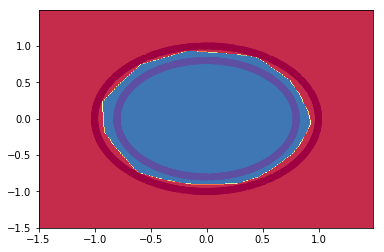

Plotting the decision boundary for number of epochs = 10.
Cross-entropy loss at the end of epoch 0: 0.29700788732214967
classification error at the end of epoch 0: 0.46136363636363636
End of train loop process.


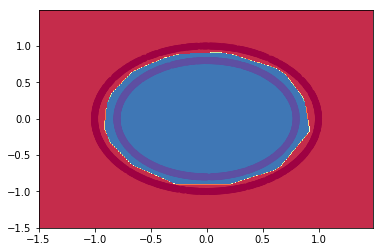

Plotting the decision boundary for number of epochs = 100.
Cross-entropy loss at the end of epoch 0: 1.2004184332193195
classification error at the end of epoch 0: 0.4420454545454545
Cross-entropy loss at the end of epoch 100: 7.075407592587099
classification error at the end of epoch 100: 0.0
Cross-entropy loss at the end of epoch 200: 7.629484667099764
classification error at the end of epoch 200: 0.0
Cross-entropy loss at the end of epoch 300: 8.014660562918792
classification error at the end of epoch 300: 0.0
Cross-entropy loss at the end of epoch 400: 8.256435452374223
classification error at the end of epoch 400: 0.0
Cross-entropy loss at the end of epoch 500: 8.50335839831989
classification error at the end of epoch 500: 0.0
Cross-entropy loss at the end of epoch 600: 8.652076886542428
classification error at the end of epoch 600: 0.0
Cross-entropy loss at the end of epoch 700: 8.811046461061245
classification error at the end of epoch 700: 0.0
Cross-entropy loss at the end of e

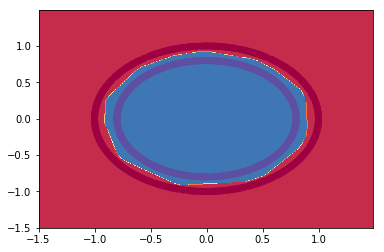

Plotting the decision boundary for number of epochs = 1000.


In [129]:
num_epoch = [10, 100, 1000]    
for n in num_epoch:
    circleNet = neuralNet(2, 15, 2, trainData.shape[0] ) # K = 2
    train_loop(circleNet, trainData, trainTarget, K, n)
    plot_decision_boundary(circleNet,trainData, np.argmax(trainTarget, axis = 1))
    print('Plotting the decision boundary for number of epochs = {}.'.format(n))
    #plotDecision(circleNet,testData)

Here we also see that as number of epochs increases, so does the capacity of the model (it can learn a more precise approximation of the circle) and its classification accuracy.

Then we vary the amount of regularization (weight decay):

Cross-entropy loss at the end of epoch 0: 1.0640960821291725
classification error at the end of epoch 0: 0.4715909090909091
End of train loop process.
No regularization:


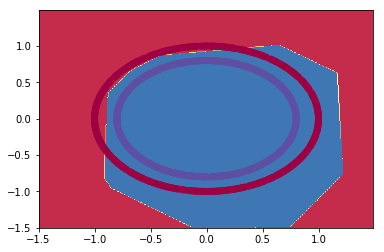

Cross-entropy loss at the end of epoch 0: 0.6250595222904928
classification error at the end of epoch 0: 0.40795454545454546
End of train loop process.
Regularization: [0.0003, 0.0003, 0.0003, 0.0003]


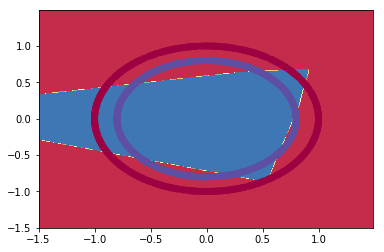

Cross-entropy loss at the end of epoch 0: 0.5102288529989611
classification error at the end of epoch 0: 0.5034090909090909
End of train loop process.
Regularization: [0.002, 0.002, 0.002, 0.002]


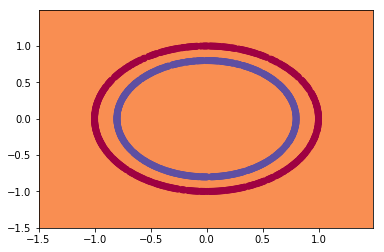

In [146]:
# No regularization
circleNet = neuralNet(2, 5, 2, trainData.shape[0]) # K = 2
train_loop(circleNet, trainData, trainTarget, K, 3) 
print('No regularization:')
plot_decision_boundary(circleNet,trainData, np.argmax(trainTarget, axis = 1))


# with regularization
circleNet = neuralNet(2, 5, 2, trainData.shape[0], regularize=[3e-4, 3e-4,  3e-4, 3e-4]) # K = 2
train_loop(circleNet, trainData, trainTarget, K, 3) 
print('Regularization: {}'.format(circleNet.regularize))
plot_decision_boundary(circleNet,trainData, np.argmax(trainTarget, axis = 1))


# with regularization
circleNet = neuralNet(2, 5, 2, trainData.shape[0], regularize=[2e-3, 2e-3,  2e-3, 2e-3]) # K = 2
train_loop(circleNet, trainData, trainTarget, K, 3) 
print('Regularization: {}'.format(circleNet.regularize))
plot_decision_boundary(circleNet,trainData, np.argmax(trainTarget, axis = 1))

We can observe that more regularization decreases the capacity of the model, since its aim is to "penalize" heavy (potentially overfit-prone) weights.

### Part 6

> As a second step, copy your existing implementation to modify it to a new implementation that will use matrix calculus (instead of a loop) on batches of size $K$ to improve efficiency. **Take the matrix expressions in numpy derived in the first part, and adapt them for a minibatch of size $K$. Show in your report what you have modified (describe the former and new expressions with the shapes of each matrix).**

(See other notebook.)

### Part 7

> Compare both implementations (with a loop and with matrix calculus) to check that they both give the same values for the gradients on the parameters, first for $K = 1$, then for $K = 10$. Display the gradients for both methods.

(See other notebook.)

### Part 8

> Time how long an epoch takes on Fashion MNIST (1 epoch = 1 full traversal through the whole training set) for $K = 100$ for both versions (loop over a minibatch and matrix caluclus).

(See other notebook.)

### Part 9

> Adapt your code to compute the error (proportion of misclassified examples) on the training set as well as the total loss on the training set during each epoch of the training procedure, and at the end of each epoch, it computes the error and average loss on the validation set and the test set. Display the 6 corresponding figures (error and average loss on train/valid/test), and write them in a log file.

(See the other notebook.)

### Part 10

> Train your network on the Fashion MNIST dataset. Plot the training/valid/test curves (error and loss as a function of the epoch number, corresponding to what you wrote in a file in the last question). Add to your report the curves obtained using your best hyperparameters, i.e. for which you obtained your best error on the validations et. We suggest 2 plots: the first one will plot the error rate (train/valid/test with different colors, show which color in a legend) and the other one for the averaged loss (on train/valid/test). You should be able to get less than 20% test error.

(See the other notebook.)